# MLADHD Experiment notebook

Notebook created by [Gonzalo Córdova](https://github.com/gonzalo-cordova-pou) in January 2023. (Last update: March 2023)

For any doubts: gonzalo.cordova@estudiantat.upc.edu

## Content:
- [Setting up the enviroment](#s1)
- [Creating a new model](#s2)
- [Training the model](#s3)
- [Testing our model](#s4)
- [Using the model](#s5)
- [Wrong predictions analysis](#s6)

<a name='s1'></a>
## Setting up our Colab enviroment

We import Python packages:

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import random
import torch
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import sampler, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import time
import os
import ipyplot

We clone [our GitHub repo](https://github.com/JulianaGSouza/MLADHD) to the enviroment. Make sure that you have access to the repository.

Finally import our MLADHD module.

In [2]:
from mlmodeling import *

Using cuda device


<a name='s2'></a>
## Setting up the Mlflow Experiment Tracking

In [3]:
from mlflow import log_metric, log_param, log_artifacts

In [4]:
mlflow.set_experiment(experiment_name="MLADHD_Experiments")

<Experiment: artifact_location='file:///E:/mladhd/MLADHD/mlruns/171971568197065632', creation_time=1679508626395, experiment_id='171971568197065632', last_update_time=1679508626395, lifecycle_stage='active', name='MLADHD_Experiments', tags={}>

In [5]:
mlflow.start_run()

<ActiveRun: >

<a name='s2'></a>
## Create a new model

The idea of case 1 is to create a model by using a pretrained PyTorch model and adding a classification layer. We will train the model freezing the pretrained model (resnet50, in this case).

- Choose a name for the model
- Indicate where the data is stored
- Choose where to save the model
- Choose a validation size

**IMPORTANT** Make sure that the model_dir exists, create the folder if necessary

In [6]:
model_name = 'test_newData'
data_dir = 'E:\\mladhd\\datasets\\data_clean\\'
models_dir = 'E:\\mladhd\\models\\'
split = (0.7, 0.1, 0.2)

In [7]:
mlflow.log_param("model_name", model_name)
mlflow.log_param("data_dir", data_dir)
mlflow.log_param("data_split", split)

(0.7, 0.1, 0.2)

Create a dictionary with the hyperparameters:

In [8]:
hyperparams = {
    'lr': 0.003, 
    'epochs': 5, 
    'batch_size': 64,
    'optimizer': 'Adam',            # options: Adam, SGD
    'loss': 'NLLLoss',              # options: NLLLoss, CrossEntropyLoss
    'pretrained_model': 'resnet50', # options: resnet50, vgg16
    'freeze_pretrained_model': True,# options: True, False
    'train_transforms': 'default',  # options: default
    'valid_transforms': 'default',    # options: default
    'test_transforms': 'default'    # options: default
}

Create a new experiment with the MLADHD Python class.

In [9]:
experiment = MLADHD(model_name, data_dir, models_dir, hyperparams)

Log hyperparams in mlflow

In [10]:
mlflow.log_params(experiment.hyperparams)

Load and split the data into train and test.

In [11]:
experiment.load_split_dataset(split)

Train size:  1553
Valid size:  221
Test size:  445


In [12]:
total_len = len(experiment.trainloader.dataset) + len(experiment.validloader.dataset) + len(experiment.testloader.dataset)
mlflow.log_param("Total dataset size", total_len)
mlflow.log_param("Train size", len(experiment.trainloader.dataset))
mlflow.log_param("Valid size", len(experiment.validloader.dataset))
mlflow.log_param("Test size", len(experiment.testloader.dataset))

445

Create a new model using the pretrained model indicated in the hyperparameters

In [13]:
experiment.create_model()

Check what pretrained model has been used.

In [14]:
experiment.hyperparams["pretrained_model"]

'resnet50'

<a name='s3'></a>
## Training the model

Now lets train our model with the train data:

In [15]:
start_time = time.time()
experiment.train_model()
dur = (time.time() - start_time)/60
print(f"Total time: {dur} minutes")
mlflow.log_param("Training_time_min", dur)

Epoch: 1/5
Batch number: 000/025, Training: Loss: 0.6774, Accuracy: 0.7031
Batch number: 005/025, Training: Loss: 0.4176, Accuracy: 0.8906
Batch number: 010/025, Training: Loss: 0.2820, Accuracy: 0.8750
Batch number: 015/025, Training: Loss: 0.1812, Accuracy: 0.9219
Batch number: 020/025, Training: Loss: 0.1754, Accuracy: 0.9062
Valid. Batch number: 000/004, Valid: Loss: 0.1632, Accuracy: 0.9531
Valid. Batch number: 001/004, Valid: Loss: 0.2130, Accuracy: 0.9375
Valid. Batch number: 002/004, Valid: Loss: 0.1358, Accuracy: 0.9844
Valid. Batch number: 003/004, Valid: Loss: 0.1536, Accuracy: 0.9310
__________
Epoch : 001
Training: Loss: 0.3319, Accuracy: 0.8583
Validation: Loss: 0.1684, Accuracy: 0.9548
__________
Epoch: 2/5
Batch number: 000/025, Training: Loss: 0.0827, Accuracy: 0.9688
Batch number: 005/025, Training: Loss: 0.0716, Accuracy: 0.9688
Batch number: 010/025, Training: Loss: 0.0553, Accuracy: 0.9688
Batch number: 015/025, Training: Loss: 0.1796, Accuracy: 0.9531
Batch number

E:\Users\ADHD Project\anaconda3\envs\env_mladhd\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'test_newData_resnet50_2023-03-23_11-15-19'.
2023/03/23 11:19:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: test_newData_resnet50_2023-03-23_11-15-19, version 1


Total time: 4.481208479404449 minutes


Created version '1' of model 'test_newData_resnet50_2023-03-23_11-15-19'.


4.481208479404449

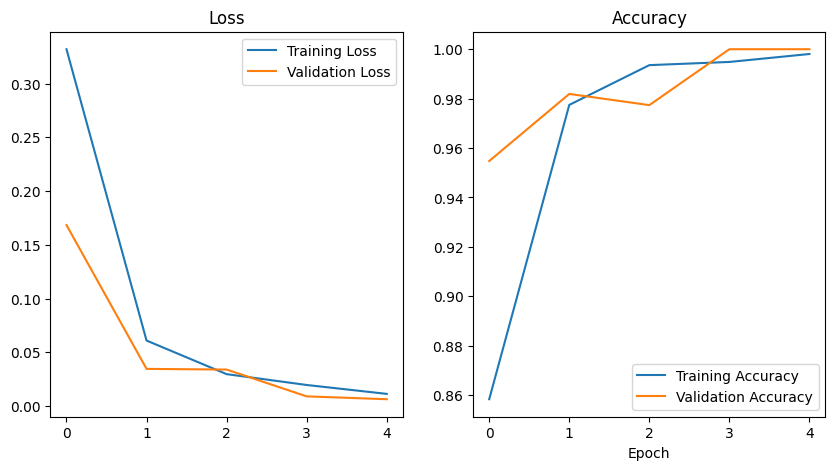

In [16]:
experiment.plot_training()

Check that the new trained model and the hyperparameters used have been stored in the indicated folder with the name *modelname_pretrainedmodel_date_time.pth* and *modelname_pretrainedmodel_date_time.json* respectively.

<a name='s4'></a>
## Test the model

Now lets test our model with the test data and see the test_loss, accuracy, precision, recall and F1-Score.

Testing model...
Test Batch number: 000, Test: Loss: 0.0057, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Batch number: 001, Test: Loss: 0.0198, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Batch number: 002, Test: Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Batch number: 003, Test: Loss: 0.0619, Accuracy: 0.9844, Precision: 0.9850, Recall: 0.9844, F1 Score: 0.9844
Test Batch number: 004, Test: Loss: 0.0080, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Batch number: 005, Test: Loss: 0.0091, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Batch number: 006, Test: Loss: 0.0194, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test: Loss: 0.0180, Accuracy: 99.7753%, Precision: 99.7846%, Recall: 99.7753%, F1 Score: 99.7763%


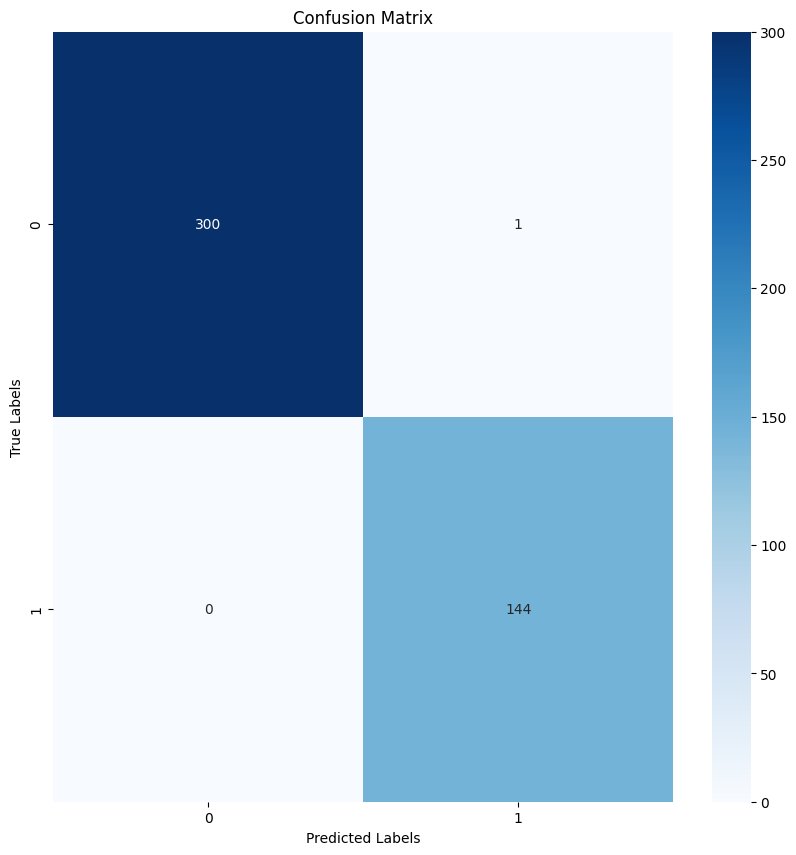

In [17]:
print("Testing model...")
experiment.test_model()

In [18]:
mlflow.end_run()

<a name='s5'></a>
## Using the model

If we have already trained a model we can load it to our enviroment in order to new predictions
We will load:
- The trained model
- The hyperparameters used for its training

In [20]:
data_dir = 'E:\\mladhd\\datasets\\data_clean\\'
models_dir = 'E:\\mladhd\\models\\'
pretrained_model = 'test_newData_resnet50_2023-03-22_16-12-03'
model_name = pretrained_model.split('_')[0]
print("Loading hyperparams...")
with open(models_dir+pretrained_model+'.json', 'r') as fp:
    hyperparams = json.load(fp)
# when loading a pretrained model, the date is updated to the current date
# so that the model is not overwritten (see __init__)
experiment2 = MLADHD(model_name, data_dir, models_dir, hyperparams)
experiment2.load_model(os.path.join(models_dir,  pretrained_model + '.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
experiment2.model = experiment2.model.to(device)

Loading hyperparams...
Model loaded from:  E:\mladhd\models\test_newData_resnet50_2023-03-22_16-12-03.pth


In [21]:
experiment2.hyperparams

{'lr': 0.003,
 'epochs': 5,
 'batch_size': 64,
 'optimizer': 'Adam',
 'loss': 'NLLLoss',
 'pretrained_model': 'resnet50',
 'freeze_pretrained_model': True,
 'train_transforms': 'default',
 'valid_transforms': 'default',
 'test_transforms': 'default'}

### One image prediction

In [22]:
label, pred, prob = experiment2.predict("E:\\mladhd\\datasets\\data_clean\\1_distracted\\distracted_amazon_one_13.jpg")
print("Real class: ", label)
print("Predicted class: ", pred, "[p =", prob, "]")

Real class:  distracted
Predicted class:  distracted [p = 0.97 ]


### N random images prediction

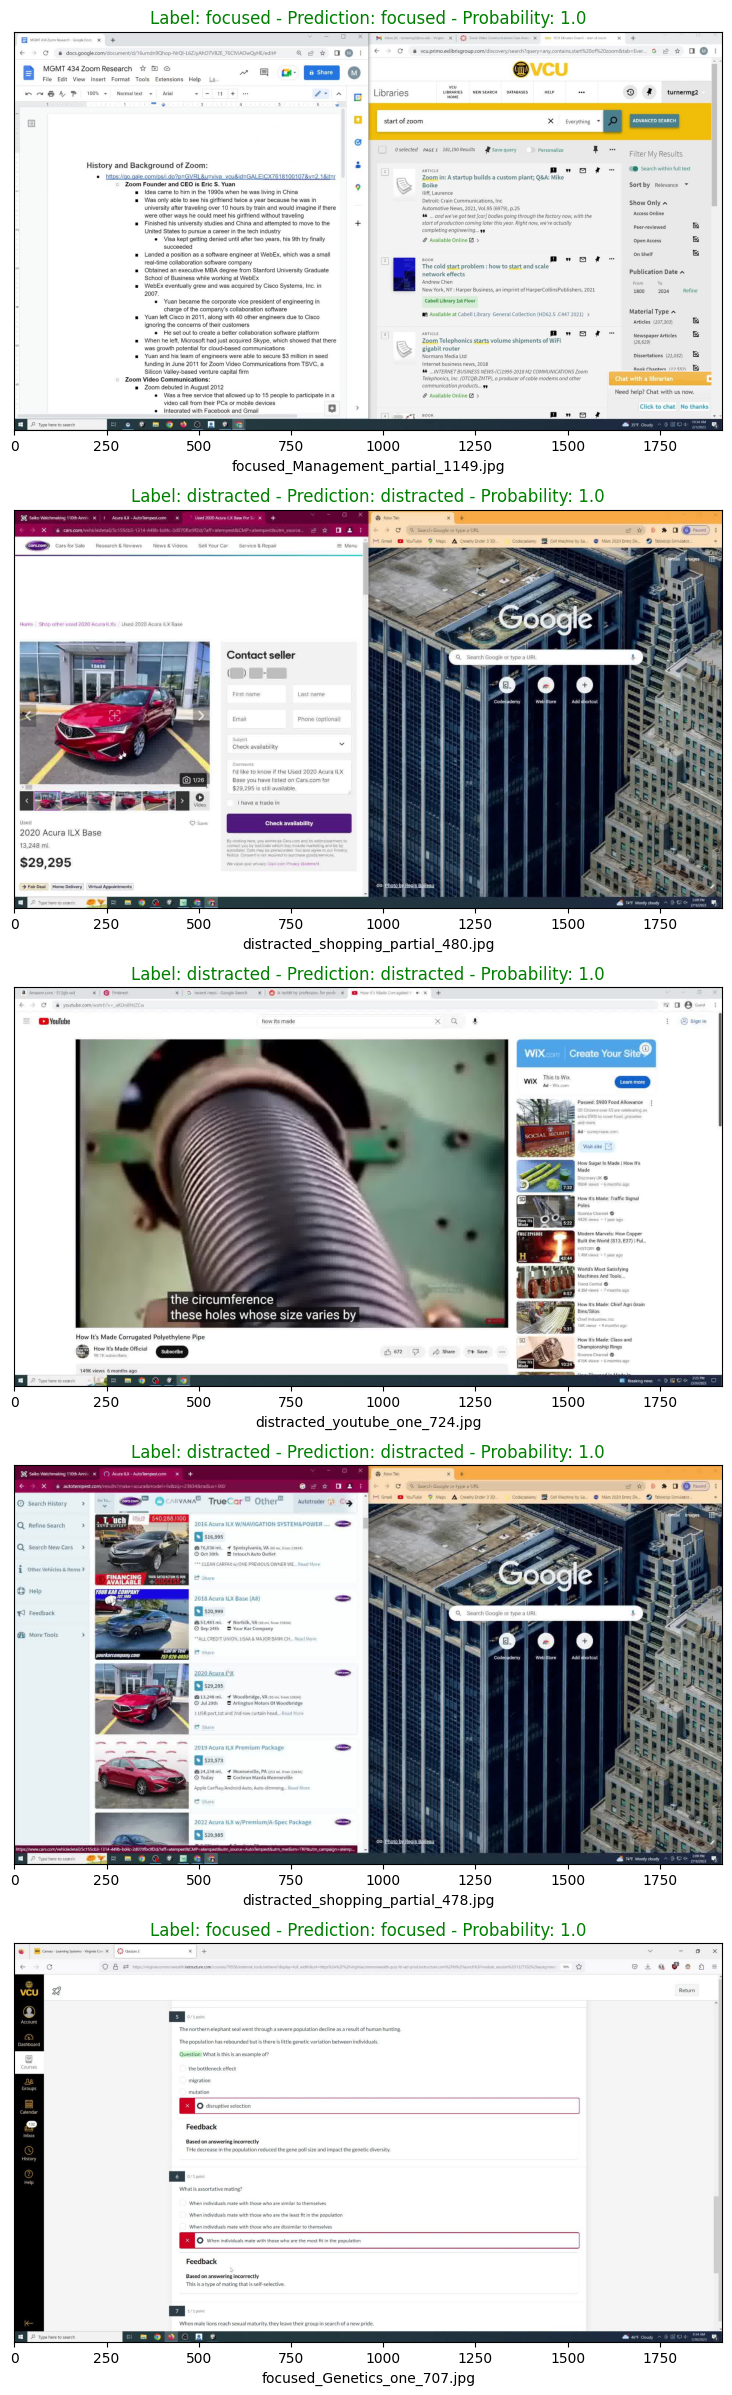

In [23]:
experiment2.test_random_images(data_dir, 5)

<a name='s6'></a>
## Wrong predictions analysis

In [24]:
errors_focused = []
errors_distracted = []
probs = []
p_list = [
    "E:\\mladhd\\datasets\\data_clean\\0_focused",
    "E:\\mladhd\\datasets\\data_clean\\1_distracted"
]
for p in p_list:
    for filename in os.listdir(p):
        f = os.path.join(p, filename)
        # checking if it is a file
        if os.path.isfile(f):
            label, pred, prob = experiment2.predict(f)
            if label != pred:
                probs.append(prob)
                if os.path.basename(p) == "0_focused":
                    errors_focused.append(os.path.join(p,filename))
                if os.path.basename(p) == "1_distracted":
                    errors_distracted.append(os.path.join(p,filename))

In [25]:
len(probs)

8

In [26]:
len(errors_focused)

4

In [27]:
len(errors_distracted)

4

In [28]:
images = errors_focused + errors_distracted
labels = ["focused"]*len(errors_focused) + ["distracted"]*len(errors_distracted)

In [29]:
images

['E:\\mladhd\\datasets\\data_clean\\0_focused\\focused_Genetics_one_766.jpg',
 'E:\\mladhd\\datasets\\data_clean\\0_focused\\focused_Genetics_partial_767.jpg',
 'E:\\mladhd\\datasets\\data_clean\\0_focused\\focused_Literature_one_874.jpg',
 'E:\\mladhd\\datasets\\data_clean\\0_focused\\focused_Social Politics_one_1481.jpg',
 'E:\\mladhd\\datasets\\data_clean\\1_distracted\\distracted_other_one_276.jpg',
 'E:\\mladhd\\datasets\\data_clean\\1_distracted\\distracted_other_one_278.jpg',
 'E:\\mladhd\\datasets\\data_clean\\1_distracted\\distracted_other_one_281.jpg',
 'E:\\mladhd\\datasets\\data_clean\\1_distracted\\distracted_pinterest_one_312.jpg']

Real label: focused
Probability of real label 0.3700000047683716


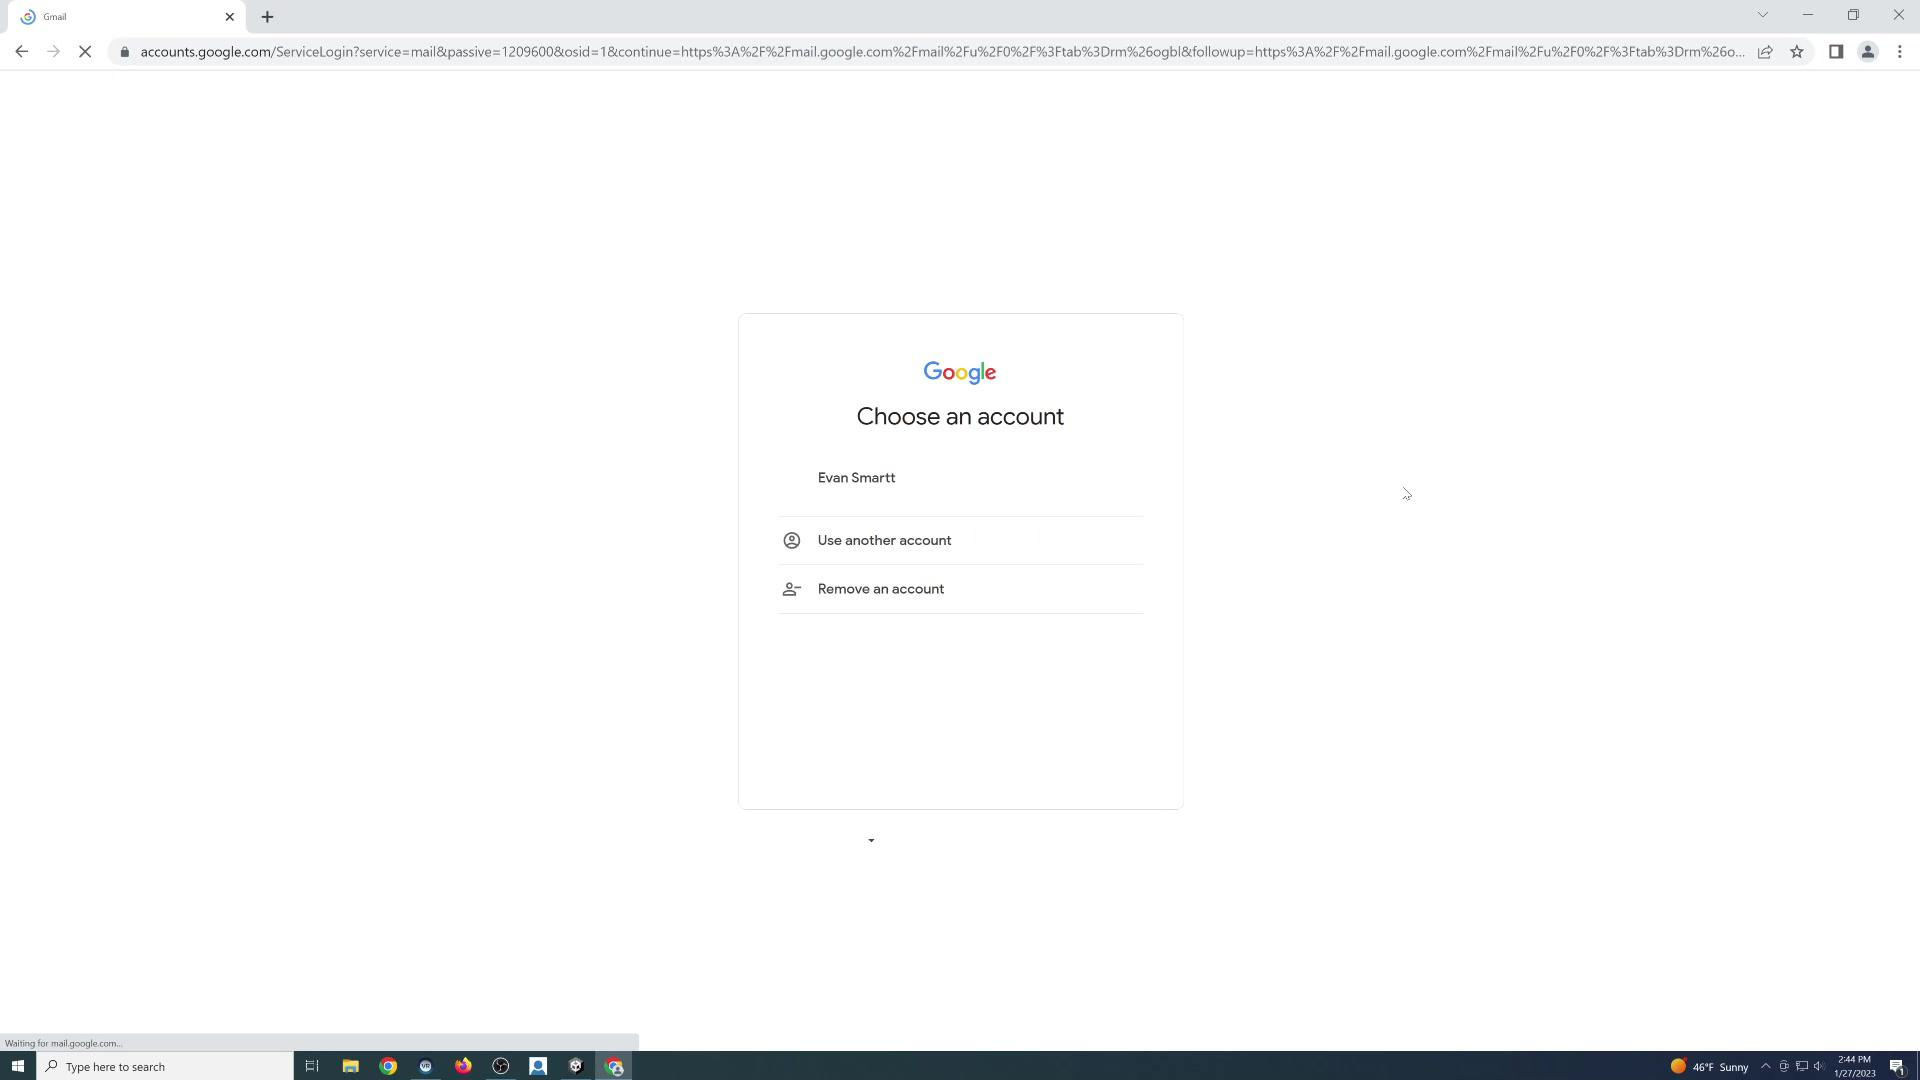

In [30]:
from IPython.display import Image
i = random.choice(range(0, len(images)))
print("Real label:", labels[i])
print("Probability of real label", 1-probs[i])
Image(filename=images[i])